### Libs and data from file

In [1]:
import os
import random
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, TextVectorization, Embedding, GRU, Bidirectional
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, concatenate
from tensorflow import keras

import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import numpy as np

# tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [2]:
BATCH_SIZE = 64
MAX_SEQ_LENGTH = 25
VOCAB_SIZE = 15_000

In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', extract=True,
                                      origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip')

PATH_TO_DATASET = pathlib.Path(path_to_zip).parent / 'spa-eng' / 'spa.txt'

In [4]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')  # Split accecented characters.
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')  # Keep space, a to z, [], and select punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')  # Add spaces around punctuation.
    text = tf.strings.strip(text)  # Strip whitespace.

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

def split_pair(pair):
    return [p[0] for p in pair], [p[1] for p in pair]

def load_data(path):
    text = path.read_text(encoding='utf-8')
    print(f"Chars in dataset: {len(text)}")

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    return pairs


pairs = load_data(PATH_TO_DATASET)
random.Random(2006).shuffle(pairs)  # 118_964 = 85_000 + 10_000 + 23 964
train_pairs, val_pairs, test_pairs = pairs[:85_000], pairs[85_000:95_000], pairs[95_000:]

ds_text = tf.data.Dataset.from_tensor_slices(split_pair(pairs)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE)

Chars in dataset: 7919056


In [5]:
print(*pairs[:5], sep='\n')
for example_input_batch, example_target_batch in ds_text.take(1):
    print(*example_input_batch[:3], sep='\n')
    print(*example_target_batch[:3], sep='\n')
    print()

example_text = tf.constant("¿Todavía está en casa?", dtype=tf.string)
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

['It was good working with you.', 'Estuvo bien trabajar contigo.']
["Don't touch my camera.", 'No toques mi cámara.']
["I know what I'm saying.", 'Yo sé lo que estoy diciendo.']
['I think they know you.', 'Yo creo que ellas te conocen.']
['I like fishing.', 'Me gusta la pesca.']
tf.Tensor(b"Don't leave things half finished.", shape=(), dtype=string)
tf.Tensor(b'Tom and Mary are going to a dance tomorrow evening.', shape=(), dtype=string)
tf.Tensor(b'My aunt brought me some flowers.', shape=(), dtype=string)
tf.Tensor(b'No dejes las cosas a medias.', shape=(), dtype=string)
tf.Tensor(b'Tom y Mary van a bailar ma\xc3\xb1ana por la tarde.', shape=(), dtype=string)
tf.Tensor(b'Mi t\xc3\xada me trajo algunas flores.', shape=(), dtype=string)

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.] [    0     0     0     0    48  2822  9586 17620 20897 19935 16457 11350
  7737  4670  3061  1817  1098   727   446   259   117    77    74    59
    19    26    15    13    13     3     2     0     0     2     2     6
     0     2     2     0     0     0     0     0     0     0     1     0
     0     1]


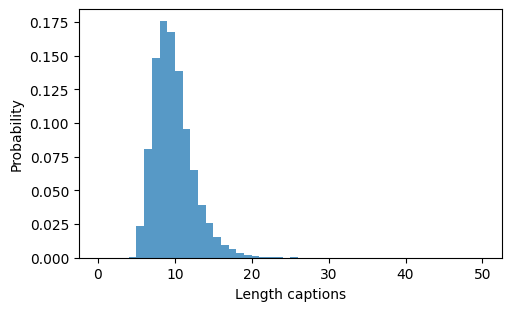

In [6]:
cap_lens = [len(p[0].split()) + 3 for p in pairs]
counts, bins = np.histogram(cap_lens, 50, range=(0., 50.))
print(bins, counts)

fig, ax = plt.subplots(figsize=(5,  3), layout='constrained')
plt.hist(bins[:-1], bins, weights=counts, density=True, facecolor='C0', alpha=0.75)
ax.set_xlabel('Length captions')
ax.set_ylabel('Probability')
plt.show()

### Tokenizer

In [7]:
source_vectorization = tf.keras.layers.TextVectorization(  # English
    standardize=tf_lower_and_split_punct,
    max_tokens=VOCAB_SIZE, output_mode="int",
    output_sequence_length=MAX_SEQ_LENGTH)

source_vectorization.adapt([p[0] for p in train_pairs])
eng_vocab = source_vectorization.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
print(eng_vocab[:18])  # Here are the first 18 words from the vocabulary


target_vectorization = tf.keras.layers.TextVectorization(  # Spanish
    standardize=tf_lower_and_split_punct,
    max_tokens=VOCAB_SIZE, output_mode="int",
    output_sequence_length=MAX_SEQ_LENGTH+1)

target_vectorization.adapt([p[1] for p in train_pairs])
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
print(spa_vocab[:18])  # Here are the first 18 words from the vocabulary

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom', 'a', '?', 'is', 'he', 'in', 'of', 'that', 'it']
['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no', 'tom', 'la', '?', '¿', 'en', 'es', 'un', 'se']


tf.Tensor(
[[  2  27 179 253 786 403   4   3   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  2   9  40  32  29  75   7  10 740 166 664   4   3   0   0   0   0   0
    0   0   0   0   0   0   0]], shape=(2, 25), dtype=int64)


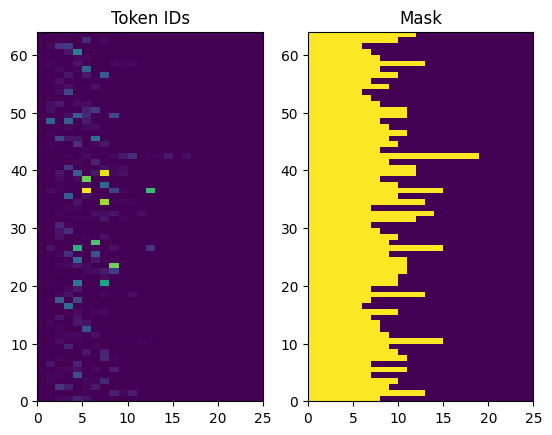

In [9]:
example_tokens = source_vectorization(example_input_batch)
print(example_tokens[:2, :])

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')
plt.show()

### Datasets

In [10]:
def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({"english": eng, "spanish": spa[:, :-1]}, spa[:, 1:])

def make_dataset(pairs, batch_size=BATCH_SIZE):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts)).batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

train_ds = make_dataset(train_pairs)
val_ds   = make_dataset(val_pairs)
test_ds  = make_dataset(test_pairs)

In [15]:
for example_input_batch, example_target_batch in train_ds.take(1):
    print(example_input_batch)
    print(example_target_batch)

{'english': <tf.Tensor: shape=(64, 25), dtype=int64, numpy=
array([[   2,   98,  593, ...,    0,    0,    0],
       [   2,    6, 2310, ...,    0,    0,    0],
       [   2,   13,   12, ...,    0,    0,    0],
       ...,
       [   2,   53,  444, ...,    0,    0,    0],
       [   2,  144,    6, ...,    0,    0,    0],
       [   2,    9,   59, ...,    0,    0,    0]], dtype=int64)>, 'spanish': <tf.Tensor: shape=(64, 25), dtype=int64, numpy=
array([[   2,  357,  542, ...,    0,    0,    0],
       [   2,   30, 2379, ...,    0,    0,    0],
       [   2,    7,   15, ...,    0,    0,    0],
       ...,
       [   2,   13,    5, ...,    0,    0,    0],
       [   2,  106,   74, ...,    0,    0,    0],
       [   2,   10,    9, ...,    0,    0,    0]], dtype=int64)>}
tf.Tensor(
[[ 357  542 7287 ...    0    0    0]
 [  30 2379    5 ...    0    0    0]
 [   7   15 4684 ...    0    0    0]
 ...
 [  13    5   65 ...    0    0    0]
 [ 106   74  801 ...    0    0    0]
 [  10    9  137 ...    

## Models

- ### RNN (GRU, seq2seq)

In [37]:
embed_dim  = 256#256
latent_dim = 1024#1024

# Encoder
source = Input(shape=(MAX_SEQ_LENGTH,), dtype="int64", name="english")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=embed_dim, mask_zero=True)(source)
enocoded_source = Bidirectional(GRU(latent_dim), merge_mode="sum")(x)

# Decoder
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=embed_dim, mask_zero=True)(past_target)
x = GRU(latent_dim, return_sequences=True)(x, initial_state=enocoded_source)
x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
next_target_pred = Dense(VOCAB_SIZE, activation="softmax")(x)

model = Model([source, past_target], next_target_pred, name="RNN_seq2seq2")

- ### Transformer (encoder + decoder)
![title](arch.png)

In [17]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # Input and output dim
        self.dense_dim = dense_dim  # Hidden dense dim
        self.num_heads = num_heads  # Num heads for MultiHeadAttention
        
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_part = Sequential([
            Dense(dense_dim, activation="relu"),
            Dense(embed_dim)], name="dense_part")
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_out = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        dense_input = self.layernorm_1(attention_out + inputs)
        dense_out = self.dense_part(dense_input)
        return self.layernorm_2(dense_input + dense_out)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True  # API Keras значит на выход будет маска
        self.embed_dim = embed_dim  # Input and output dim
        self.dense_dim = dense_dim  # Hidden dense dim
        self.num_heads = num_heads  # Num heads for MultiHeadAttention
        
        self.attention_1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_part = Sequential([
            Dense(dense_dim, activation="relu"),
            Dense(embed_dim)], name="dense_part")
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        attention_1_out = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_1_out = self.layernorm_1(attention_1_out + inputs)
        
        attention_2_out = self.attention_2(
            query=attention_1_out,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask)
        attention_2_out = self.layernorm_2(attention_2_out + attention_2_out)
        
        dense_out = self.dense_part(attention_2_out)
        out = self.layernorm_3(attention_2_out + dense_out)
        return out
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)  # (batch, seq, emb)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask_falatten = tf.cast(i >= j, dtype="int32")  # bool to (1 or 0)
        mask = tf.reshape(mask_falatten, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(  # copy mask from 1 to batch_size
            [tf.expand_dims(batch_size, -1),
            tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)
        
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [12]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length  # Длина последовательности
        self.input_dim = input_dim              # Всего токенов
        self.output_dim = output_dim            # Размер выходного вектора (токен + позиция)
        
        self.token_embeddings = Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True)  # mask_zero=True
        self.position_embeddings = Embedding(input_dim=sequence_length, output_dim=output_dim)
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions  # concatene
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [18]:
embed_dim = 256
dense_dim = 2048
num_heads = 2

# Encoder
encoder_inputs = Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(input_dim=VOCAB_SIZE, output_dim=embed_dim, sequence_length=MAX_SEQ_LENGTH)(encoder_inputs)
enocoded_source = TransformerEncoder(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads)(x)

# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(input_dim=VOCAB_SIZE, output_dim=embed_dim, sequence_length=MAX_SEQ_LENGTH)(decoder_inputs)
x = TransformerDecoder(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads)(x, enocoded_source)

x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
decoder_outputs = Dense(VOCAB_SIZE, activation="softmax")(x)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="Tranformer")

### Compile

In [19]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f"{model.name}.keras",
        save_best_only=True,
        monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=7),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.666,
        min_lr=6e-5,
        patience=2),
#     tf.keras.callbacks.TensorBoard(
#         log_dir="logs",
#         histogram_freq=2,
#         write_images=True)
]

model.compile(optimizer=RMSprop(0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "Tranformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_4 (Positi  (None, None, 256)   3846400     ['english[0][0]']                
 onalEmbedding)                                                                                   
                                                                                                  
 positional_embedding_5 (Positi  (None, None, 256)   3846400     ['spanish[0][0]']       

### Fit

In [20]:
model.fit(train_ds, validation_data=val_ds, callbacks=callbacks, epochs=100) #53 66 67.5   77s

Epoch 1/100
1329/1329 [==============================] - 87s 63ms/step - loss: 1.6444 - accuracy: 0.3746 - val_loss: 1.4174 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 2/100
1329/1329 [==============================] - 84s 63ms/step - loss: 1.4361 - accuracy: 0.4453 - val_loss: 1.2971 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 3/100
1329/1329 [==============================] - 81s 61ms/step - loss: 1.3211 - accuracy: 0.4829 - val_loss: 1.2068 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 4/100
1329/1329 [==============================] - 83s 62ms/step - loss: 1.2437 - accuracy: 0.5099 - val_loss: 1.1493 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 5/100
1329/1329 [==============================] - 82s 62ms/step - loss: 1.1798 - accuracy: 0.5326 - val_loss: 1.0990 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 6/100
1329/1329 [==============================] - 82s 62ms/step - loss: 1.1351 - accuracy: 0.5503 - val_loss: 1.0694 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 7/100
1329/1329 [=================

KeyboardInterrupt: 

### Test models in translate

In [27]:
# model = load_model("RNN_seq2seq.keras")  # Tranformer RNN_seq2seq
# print(f"Test acc: {model.evaluate(test_ds)[1]:.3f}")

def decode_sequence(input_sentence, is_transfomer=False):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[START]"
    for i in range(MAX_SEQ_LENGTH):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        if is_transfomer:
            tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        next_token_predictions = model.predict([tokenized_input_sentence, tokenized_target_sentence], verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[END]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in train_pairs]  # train_pairs test_pairs
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence, True))

-
You shouldn't have lied to me.
[START] no que deberias me [UNK] . . [END]
-
Don't go there.
[START] no a alli estar . alli [END]
-
Food should be chewed before being swallowed.
[START] la comida comida antes antes de de [UNK] la . [UNK] [END]
-
He was accompanied by his wife.
[START] fue estaba por [UNK] su . madre [END]
-
I am tired of the work.
[START] estoy cansado de del el trabajo trabajo . . [END]
-
I don't want to go to work today.
[START] no que quiero trabajar ir . . [END]
-
I agreed.
[START] yo . . [END]
-
I would like to go to America one day.
[START] me una gustaria escuela ir en en un un dia dia . . [END]
-
Didn't you hear the doorbell?
[START] ¿ no que le [UNK] [UNK] ? ? [END]
-
How you've grown!
[START] como que has ! [UNK] [END]
-
Tom understands what it takes to survive.
[START] tom que lo esta que haciendo te . [UNK] [END]
-
You have many friends.
[START] tienes muchos amigos amigos . . [END]
-
It's very clean.
[START] es muy muy . . [END]
-
On my way here, the stro

#### Another

In [ ]:
class PositionalEncoding(layers.Layer):
    def __init__(self, max_sentence_len=50, embedding_size=256, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if not embedding_size % 2 == 0:
            raise ValueError("The `embedding_size` must be even.")

        p, i = np.meshgrid(np.arange(max_sentence_len), np.arange(embedding_size // 2))
        pos_emb = np.empty((1, max_sentence_len, embedding_size))
        pos_emb[:, :, 0::2] = np.sin(p / 10_000 ** (2 * i / embedding_size)).T
        pos_emb[:, :, 1::2] = np.cos(p / 10_000 ** (2 * i / embedding_size)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.positional_embedding[:, :batch_max_length]